In [1]:
import pandas as pd
from pathlib import Path

#### We shall use <read_csv, DataFrame, concat> from 'pandas'

In [2]:
healthy_path = Path("infypoc/result_healthy_pandas.csv")

In [3]:
df_healthy = pd.read_csv(healthy_path, engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235


In [4]:
df_healthy.loc[df_healthy[1] == 100]

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235
...,...,...,...,...
485638,485638,100,0.035673,0.125122
485639,485639,100,-0.004590,0.124916
485640,485640,100,-0.023574,0.109302
485641,485641,100,0.005215,0.052185


In [5]:
faulty_path = Path("infypoc/result_faulty_pandas.csv")

In [6]:
df_faulty = pd.read_csv(faulty_path, engine='python', header=None)
df_faulty.head()

,0,1,2,3
0,0,105,-0.083004,-0.402075
1,1,105,-0.195734,-0.004725
2,2,105,0.233419,-0.106631
3,3,105,0.103958,-0.074169
4,4,105,-0.181115,0.208947


In [7]:
import numpy as np
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.layers import Activation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [8]:
def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))


In [9]:
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,125)

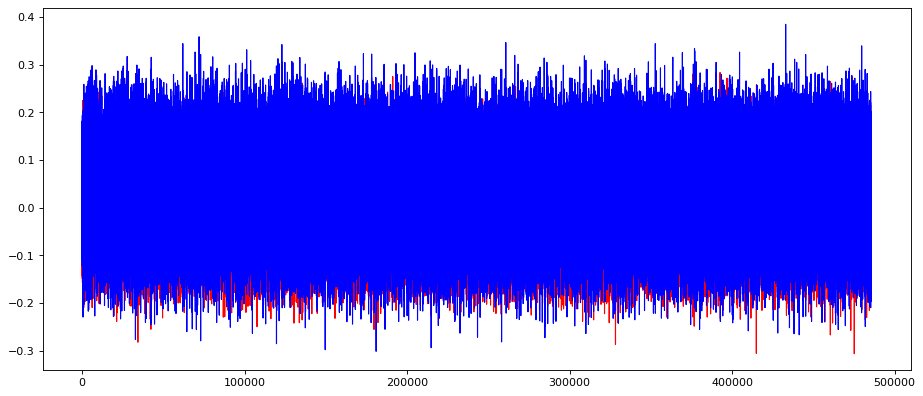

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)

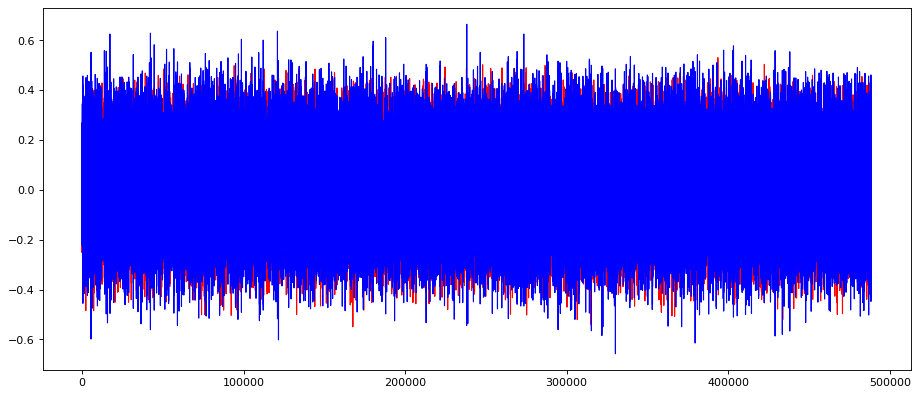

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)

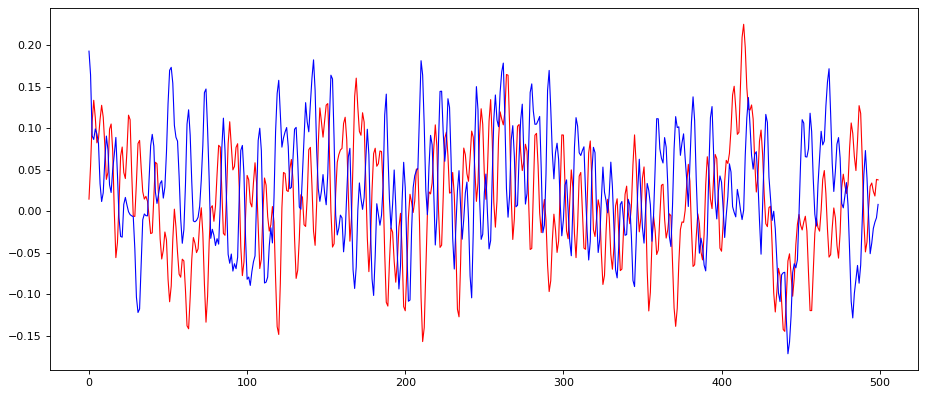

In [12]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

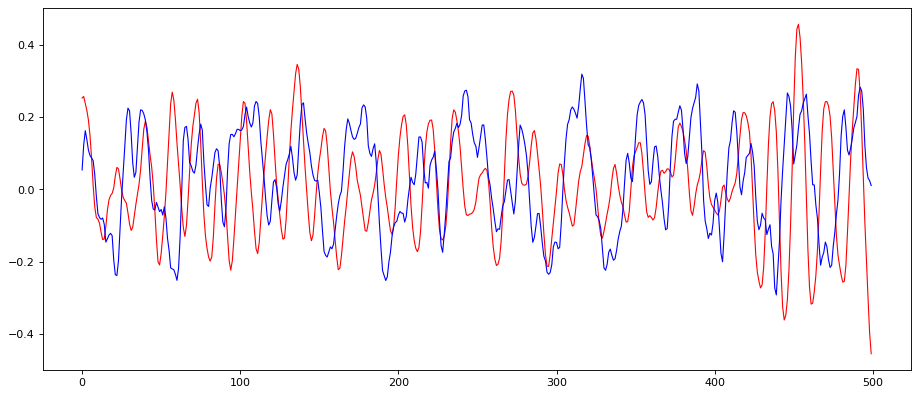

In [13]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

In [14]:
class LossHist(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [15]:
timesteps = 100
dim = 2
lossHistory = LossHist()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [24]:
import tensorflow as tf
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [25]:
def create_trimmed_recording(df,file_id):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return recording_trimmed


In [27]:
df_healthy.drop(0,1).drop(2,1).drop(3,1)

,1
0,100
1,100
2,100
3,100
4,100
...,...
1213479,98
1213480,98
1213481,98
1213482,98


In [28]:
pd.unique(df_healthy.iloc[:,1])

array([100,  97,  98], dtype=int64)

In [29]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses


Staring training on 100
Epoch 1/20
68/68 [==============================] - 5s 54ms/step - loss: 0.0496 - val_loss: 0.0368
Epoch 2/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0316 - val_loss: 0.0165
Epoch 3/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 4/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 5/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 6/20
68/68 [==============================] - 3s 50ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 7/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 8/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/20
68/68 [==============================] - 3s 51ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 10/20
68/68 [==============================] - 3s 50ms/step - loss: 0.0036 - va

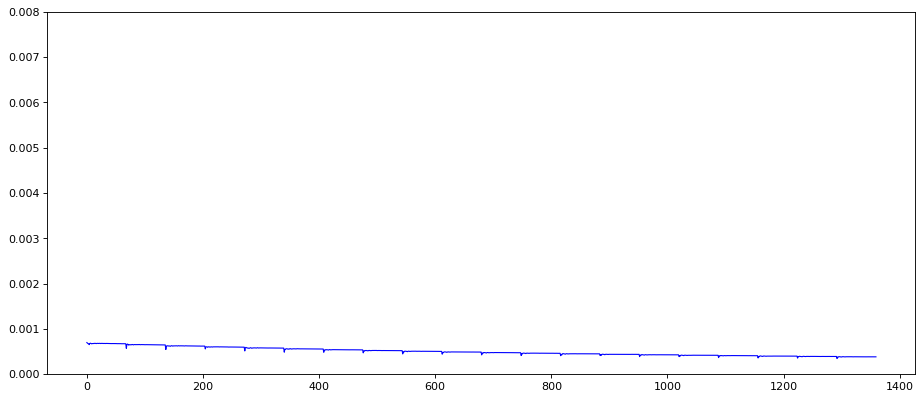

In [30]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [31]:
start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

Staring training on 105
Epoch 1/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 2/20
17/17 [==============================] - 1s 50ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/20
17/17 [==============================] - 1s 49ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/20
17/17 [==============================] - 1s 50ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/20
17/17 [==============================] - 1s 50ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/20
17/17 [==============================] - 1s 51ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/20
17/17 [==============================] - 1s 53ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/20
17/17 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/20
17/17 [==============================] - 1s 52ms/step - loss: 0.0018 - va

In [32]:
file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses


Staring training on 105
Epoch 1/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/20
17/17 [==============================] - 1s 53ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/20
17/17 [==============================] - 1s 50ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/20
17/17 [==============================] - 1s 56ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/20
17/17 [==============================] - 1s 56ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/20
17/17 [==============================] - 1s 53ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/20
17/17 [==============================] - 1s 52ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/20
17/17 [==============================] - 1s 52ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/20
17/17 [==============================] - 1s 51ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/20
17/17 [==============================] - 1s 58ms/step - loss: 9.8623e-04 

18/18 [==============================] - 1s 51ms/step - loss: 8.5799e-04 - val_loss: 9.3144e-04
Epoch 16/20
18/18 [==============================] - 1s 52ms/step - loss: 8.3983e-04 - val_loss: 8.5365e-04
Epoch 17/20
18/18 [==============================] - 1s 51ms/step - loss: 8.2414e-04 - val_loss: 9.2088e-04
Epoch 18/20
18/18 [==============================] - 1s 51ms/step - loss: 8.0820e-04 - val_loss: 8.6455e-04
Epoch 19/20
18/18 [==============================] - 1s 51ms/step - loss: 8.0264e-04 - val_loss: 8.7198e-04
Epoch 20/20
18/18 [==============================] - 1s 52ms/step - loss: 7.8381e-04 - val_loss: 8.3933e-04
Finished training on 108 after 78.9479033946991 seconds
Staring training on 109
Epoch 1/20
34/34 [==============================] - 2s 53ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 2/20
34/34 [==============================] - 2s 50ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/20
34/34 [==============================] - 2s 51ms/step - loss: 0.0014 - val_

68/68 [==============================] - 3s 49ms/step - loss: 3.5202e-04 - val_loss: 3.6327e-04
Epoch 10/20
68/68 [==============================] - 3s 51ms/step - loss: 3.3982e-04 - val_loss: 2.7345e-04
Epoch 11/20
68/68 [==============================] - 3s 49ms/step - loss: 3.7294e-04 - val_loss: 4.3381e-04
Epoch 12/20
68/68 [==============================] - 3s 49ms/step - loss: 3.0952e-04 - val_loss: 2.0647e-04
Epoch 13/20
68/68 [==============================] - 3s 49ms/step - loss: 2.5624e-04 - val_loss: 3.4320e-04
Epoch 14/20
68/68 [==============================] - 3s 49ms/step - loss: 3.9380e-04 - val_loss: 5.4302e-04
Epoch 15/20
68/68 [==============================] - 3s 48ms/step - loss: 4.0285e-04 - val_loss: 3.3217e-04
Epoch 16/20
68/68 [==============================] - 3s 48ms/step - loss: 3.5129e-04 - val_loss: 3.3842e-04
Epoch 17/20
68/68 [==============================] - 3s 49ms/step - loss: 3.8057e-04 - val_loss: 6.0191e-04
Epoch 18/20
68/68 [=====================

17/17 [==============================] - 1s 54ms/step - loss: 2.8824e-04 - val_loss: 2.6558e-04
Epoch 3/20
17/17 [==============================] - 1s 54ms/step - loss: 2.8481e-04 - val_loss: 3.0453e-04
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 2.8616e-04 - val_loss: 2.6615e-04
Epoch 5/20
17/17 [==============================] - 1s 54ms/step - loss: 2.8326e-04 - val_loss: 2.8965e-04
Epoch 6/20
17/17 [==============================] - 1s 52ms/step - loss: 2.8229e-04 - val_loss: 2.4782e-04
Epoch 7/20
17/17 [==============================] - 1s 51ms/step - loss: 2.7907e-04 - val_loss: 2.9846e-04
Epoch 8/20
17/17 [==============================] - 1s 52ms/step - loss: 2.8019e-04 - val_loss: 2.5906e-04
Epoch 9/20
17/17 [==============================] - 1s 51ms/step - loss: 2.7791e-04 - val_loss: 2.7692e-04
Epoch 10/20
17/17 [==============================] - 1s 53ms/step - loss: 2.7638e-04 - val_loss: 2.4100e-04
Epoch 11/20
17/17 [============================

68/68 [==============================] - 3s 49ms/step - loss: 2.9756e-04 - val_loss: 3.2251e-04
Epoch 17/20
68/68 [==============================] - 3s 49ms/step - loss: 2.8204e-04 - val_loss: 2.8266e-04
Epoch 18/20
68/68 [==============================] - 3s 49ms/step - loss: 3.0148e-04 - val_loss: 3.1806e-04
Epoch 19/20
68/68 [==============================] - 3s 49ms/step - loss: 2.5112e-04 - val_loss: 2.1713e-04
Epoch 20/20
68/68 [==============================] - 3s 49ms/step - loss: 2.5234e-04 - val_loss: 2.4722e-04
Finished training on 124 after 569.5431461334229 seconds
Staring training on 125
Epoch 1/20
68/68 [==============================] - 3s 49ms/step - loss: 3.0695e-04 - val_loss: 2.8740e-04
Epoch 2/20
68/68 [==============================] - 3s 49ms/step - loss: 2.7917e-04 - val_loss: 2.7082e-04
Epoch 3/20
68/68 [==============================] - 3s 49ms/step - loss: 2.6942e-04 - val_loss: 3.1306e-04
Epoch 4/20
68/68 [==============================] - 3s 48ms/step - los

Epoch 11/20
17/17 [==============================] - 1s 53ms/step - loss: 6.6695e-04 - val_loss: 6.7160e-04
Epoch 12/20
17/17 [==============================] - 1s 52ms/step - loss: 6.4800e-04 - val_loss: 5.9324e-04
Epoch 13/20
17/17 [==============================] - 1s 51ms/step - loss: 6.5524e-04 - val_loss: 6.7651e-04
Epoch 14/20
17/17 [==============================] - 1s 52ms/step - loss: 7.5778e-04 - val_loss: 7.8521e-04
Epoch 15/20
17/17 [==============================] - 1s 52ms/step - loss: 7.8014e-04 - val_loss: 8.2510e-04
Epoch 16/20
17/17 [==============================] - 1s 52ms/step - loss: 8.1109e-04 - val_loss: 7.1091e-04
Epoch 17/20
17/17 [==============================] - 1s 52ms/step - loss: 7.4814e-04 - val_loss: 7.4037e-04
Epoch 18/20
17/17 [==============================] - 1s 53ms/step - loss: 7.5719e-04 - val_loss: 7.7452e-04
Epoch 19/20
17/17 [==============================] - 1s 52ms/step - loss: 8.1828e-04 - val_loss: 9.2805e-04
Epoch 20/20
17/17 [=========

Epoch 6/20
68/68 [==============================] - 3s 48ms/step - loss: 7.3399e-04 - val_loss: 6.3680e-04
Epoch 7/20
68/68 [==============================] - 3s 48ms/step - loss: 7.3880e-04 - val_loss: 7.1281e-04
Epoch 8/20
68/68 [==============================] - 3s 49ms/step - loss: 7.3631e-04 - val_loss: 6.7324e-04
Epoch 9/20
68/68 [==============================] - 3s 49ms/step - loss: 7.2756e-04 - val_loss: 7.1424e-04
Epoch 10/20
68/68 [==============================] - 4s 52ms/step - loss: 6.7986e-04 - val_loss: 6.2138e-04
Epoch 11/20
68/68 [==============================] - 3s 51ms/step - loss: 6.3737e-04 - val_loss: 6.0035e-04
Epoch 12/20
68/68 [==============================] - 3s 50ms/step - loss: 6.0788e-04 - val_loss: 6.6392e-04
Epoch 13/20
68/68 [==============================] - 3s 49ms/step - loss: 7.4275e-04 - val_loss: 6.2862e-04
Epoch 14/20
68/68 [==============================] - 3s 49ms/step - loss: 7.3550e-04 - val_loss: 6.5836e-04
Epoch 15/20
68/68 [=============

17/17 [==============================] - 1s 51ms/step - loss: 5.6707e-04 - val_loss: 5.8268e-04
Finished training on 145 after 989.5205192565918 seconds
Staring training on 146
Epoch 1/20
17/17 [==============================] - 1s 56ms/step - loss: 5.5337e-04 - val_loss: 5.1555e-04
Epoch 2/20
17/17 [==============================] - 1s 52ms/step - loss: 5.4341e-04 - val_loss: 5.3435e-04
Epoch 3/20
17/17 [==============================] - 1s 51ms/step - loss: 5.3365e-04 - val_loss: 5.5637e-04
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 5.2722e-04 - val_loss: 5.4998e-04
Epoch 5/20
17/17 [==============================] - 1s 52ms/step - loss: 5.4043e-04 - val_loss: 5.3482e-04
Epoch 6/20
17/17 [==============================] - 1s 52ms/step - loss: 5.2516e-04 - val_loss: 5.7145e-04
Epoch 7/20
17/17 [==============================] - 1s 51ms/step - loss: 5.3239e-04 - val_loss: 5.0357e-04
Epoch 8/20
17/17 [==============================] - 1s 52ms/step - loss: 5

68/68 [==============================] - 4s 53ms/step - loss: 3.3111e-04 - val_loss: 3.7422e-04
Epoch 14/20
68/68 [==============================] - 3s 49ms/step - loss: 4.4154e-04 - val_loss: 4.3041e-04
Epoch 15/20
68/68 [==============================] - 3s 49ms/step - loss: 5.3508e-04 - val_loss: 3.5489e-04
Epoch 16/20
68/68 [==============================] - 3s 50ms/step - loss: 5.0618e-04 - val_loss: 6.8705e-04
Epoch 17/20
68/68 [==============================] - 3s 49ms/step - loss: 5.0839e-04 - val_loss: 4.6801e-04
Epoch 18/20
68/68 [==============================] - 3s 48ms/step - loss: 5.0762e-04 - val_loss: 3.9797e-04
Epoch 19/20
68/68 [==============================] - 3s 49ms/step - loss: 4.9921e-04 - val_loss: 6.0124e-04
Epoch 20/20
68/68 [==============================] - 3s 48ms/step - loss: 4.9785e-04 - val_loss: 6.8351e-04
Finished training on 149 after 1116.8901624679565 seconds
Staring training on 150
Epoch 1/20
68/68 [==============================] - 3s 50ms/step -

17/17 [==============================] - 1s 51ms/step - loss: 4.5988e-04 - val_loss: 4.4845e-04
Epoch 7/20
17/17 [==============================] - 1s 51ms/step - loss: 4.7219e-04 - val_loss: 2.7148e-04
Epoch 8/20
17/17 [==============================] - 1s 51ms/step - loss: 4.5499e-04 - val_loss: 4.5507e-04
Epoch 9/20
17/17 [==============================] - 1s 51ms/step - loss: 4.5471e-04 - val_loss: 4.8728e-04
Epoch 10/20
17/17 [==============================] - 1s 51ms/step - loss: 4.6287e-04 - val_loss: 2.6154e-04
Epoch 11/20
17/17 [==============================] - 1s 51ms/step - loss: 4.4542e-04 - val_loss: 5.2761e-04
Epoch 12/20
17/17 [==============================] - 1s 51ms/step - loss: 4.4926e-04 - val_loss: 4.7442e-04
Epoch 13/20
17/17 [==============================] - 1s 52ms/step - loss: 4.5477e-04 - val_loss: 2.5988e-04
Epoch 14/20
17/17 [==============================] - 1s 51ms/step - loss: 4.4390e-04 - val_loss: 5.1277e-04
Epoch 15/20
17/17 [========================

Epoch 20/20
19/19 [==============================] - 1s 49ms/step - loss: 5.6176e-04 - val_loss: 5.6259e-04
Finished training on 161 after 1350.889656305313 seconds
Staring training on 162
Epoch 1/20
68/68 [==============================] - 3s 50ms/step - loss: 2.8785e-04 - val_loss: 2.4881e-04
Epoch 2/20
68/68 [==============================] - 3s 48ms/step - loss: 2.4140e-04 - val_loss: 3.0248e-04
Epoch 3/20
68/68 [==============================] - 3s 48ms/step - loss: 2.3709e-04 - val_loss: 2.9148e-04
Epoch 4/20
68/68 [==============================] - 3s 48ms/step - loss: 2.6450e-04 - val_loss: 4.3764e-04
Epoch 5/20
68/68 [==============================] - 3s 50ms/step - loss: 2.5468e-04 - val_loss: 3.7261e-04
Epoch 6/20
68/68 [==============================] - 3s 48ms/step - loss: 2.5201e-04 - val_loss: 4.4869e-04
Epoch 7/20
68/68 [==============================] - 3s 48ms/step - loss: 2.9330e-04 - val_loss: 3.0583e-04
Epoch 8/20
68/68 [==============================] - 3s 50ms/st

17/17 [==============================] - 1s 52ms/step - loss: 2.6583e-04 - val_loss: 2.2175e-04
Epoch 14/20
17/17 [==============================] - 1s 51ms/step - loss: 2.6968e-04 - val_loss: 2.7572e-04
Epoch 15/20
17/17 [==============================] - 1s 53ms/step - loss: 2.7110e-04 - val_loss: 2.5622e-04
Epoch 16/20
17/17 [==============================] - 1s 52ms/step - loss: 2.6852e-04 - val_loss: 2.0077e-04
Epoch 17/20
17/17 [==============================] - 1s 52ms/step - loss: 2.5867e-04 - val_loss: 2.3935e-04
Epoch 18/20
17/17 [==============================] - 1s 52ms/step - loss: 2.6191e-04 - val_loss: 2.7760e-04
Epoch 19/20
17/17 [==============================] - 1s 52ms/step - loss: 2.6446e-04 - val_loss: 2.5242e-04
Epoch 20/20
17/17 [==============================] - 1s 52ms/step - loss: 2.6116e-04 - val_loss: 2.0367e-04
Finished training on 169 after 1574.4746100902557 seconds
Staring training on 170
Epoch 1/20
17/17 [==============================] - 1s 56ms/step -

9/9 [==============================] - 0s 56ms/step - loss: 4.3488e-04 - val_loss: 5.1565e-04
Epoch 7/20
9/9 [==============================] - 0s 56ms/step - loss: 3.9471e-04 - val_loss: 4.8960e-04
Epoch 8/20
9/9 [==============================] - 0s 56ms/step - loss: 5.1044e-04 - val_loss: 5.7041e-04
Epoch 9/20
9/9 [==============================] - 0s 55ms/step - loss: 5.3585e-04 - val_loss: 5.7850e-04
Epoch 10/20
9/9 [==============================] - 0s 55ms/step - loss: 6.0424e-04 - val_loss: 4.6281e-04
Epoch 11/20
9/9 [==============================] - 0s 56ms/step - loss: 5.8041e-04 - val_loss: 4.2288e-04
Epoch 12/20
9/9 [==============================] - 0s 55ms/step - loss: 5.9299e-04 - val_loss: 4.2289e-04
Epoch 13/20
9/9 [==============================] - 0s 55ms/step - loss: 5.7710e-04 - val_loss: 3.3111e-04
Epoch 14/20
9/9 [==============================] - 0s 55ms/step - loss: 5.7481e-04 - val_loss: 4.1990e-04
Epoch 15/20
9/9 [==============================] - 0s 55ms/st

17/17 [==============================] - 1s 51ms/step - loss: 2.7919e-04 - val_loss: 2.1516e-04
Finished training on 185 after 1797.9353148937225 seconds
Staring training on 186
Epoch 1/20
17/17 [==============================] - 1s 55ms/step - loss: 2.4453e-04 - val_loss: 2.7262e-04
Epoch 2/20
17/17 [==============================] - 1s 51ms/step - loss: 2.8352e-04 - val_loss: 1.4979e-04
Epoch 3/20
17/17 [==============================] - 1s 51ms/step - loss: 2.1506e-04 - val_loss: 2.3049e-04
Epoch 4/20
17/17 [==============================] - 1s 52ms/step - loss: 2.4479e-04 - val_loss: 1.2080e-04
Epoch 5/20
17/17 [==============================] - 1s 51ms/step - loss: 2.1779e-04 - val_loss: 1.2451e-04
Epoch 6/20
17/17 [==============================] - 1s 51ms/step - loss: 3.1375e-04 - val_loss: 2.6953e-04
Epoch 7/20
17/17 [==============================] - 1s 51ms/step - loss: 3.2087e-04 - val_loss: 5.1115e-04
Epoch 8/20
17/17 [==============================] - 1s 52ms/step - loss: 

35/35 [==============================] - 2s 50ms/step - loss: 3.1136e-04 - val_loss: 2.2957e-04
Epoch 14/20
35/35 [==============================] - 2s 49ms/step - loss: 2.7362e-04 - val_loss: 3.1180e-04
Epoch 15/20
35/35 [==============================] - 2s 50ms/step - loss: 2.9918e-04 - val_loss: 3.1215e-04
Epoch 16/20
35/35 [==============================] - 2s 50ms/step - loss: 3.0529e-04 - val_loss: 8.0945e-05
Epoch 17/20
35/35 [==============================] - 2s 49ms/step - loss: 3.5551e-04 - val_loss: 3.3482e-04
Epoch 18/20
35/35 [==============================] - 2s 50ms/step - loss: 2.6717e-04 - val_loss: 2.1272e-04
Epoch 19/20
35/35 [==============================] - 2s 49ms/step - loss: 3.2393e-04 - val_loss: 2.2380e-04
Epoch 20/20
35/35 [==============================] - 2s 49ms/step - loss: 2.3789e-04 - val_loss: 2.1176e-04
Finished training on 189 after 1891.088279247284 seconds
Staring training on 190
Epoch 1/20
68/68 [==============================] - 3s 50ms/step - 

17/17 [==============================] - 1s 51ms/step - loss: 2.5060e-04 - val_loss: 3.7855e-04
Epoch 7/20
17/17 [==============================] - 1s 50ms/step - loss: 3.0065e-04 - val_loss: 2.5832e-04
Epoch 8/20
17/17 [==============================] - 1s 51ms/step - loss: 2.4385e-04 - val_loss: 3.3147e-04
Epoch 9/20
17/17 [==============================] - 1s 52ms/step - loss: 2.6516e-04 - val_loss: 2.1388e-04
Epoch 10/20
17/17 [==============================] - 1s 51ms/step - loss: 1.8376e-04 - val_loss: 1.9001e-04
Epoch 11/20
17/17 [==============================] - 1s 51ms/step - loss: 1.8203e-04 - val_loss: 2.7707e-04
Epoch 12/20
17/17 [==============================] - 1s 51ms/step - loss: 2.6044e-04 - val_loss: 2.4974e-04
Epoch 13/20
17/17 [==============================] - 1s 51ms/step - loss: 2.9877e-04 - val_loss: 3.3946e-04
Epoch 14/20
17/17 [==============================] - 1s 51ms/step - loss: 3.2163e-04 - val_loss: 3.9933e-04
Epoch 15/20
17/17 [========================

Epoch 20/20
17/17 [==============================] - 1s 52ms/step - loss: 2.0108e-04 - val_loss: 2.4075e-04
Finished training on 200 after 2171.5112447738647 seconds
Staring training on 201
Epoch 1/20
35/35 [==============================] - 2s 51ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 2/20
35/35 [==============================] - 2s 49ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/20
35/35 [==============================] - 2s 49ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 4/20
35/35 [==============================] - 2s 48ms/step - loss: 0.0020 - val_loss: 6.0718e-04
Epoch 5/20
35/35 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 5.7229e-04
Epoch 6/20
35/35 [==============================] - 2s 48ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 7/20
35/35 [==============================] - 2s 49ms/step - loss: 0.0016 - val_loss: 5.8882e-04
Epoch 8/20
35/35 [==============================] - 2s 49ms/step - loss: 0.0013 - val_loss: 6.1491e-04
Ep

68/68 [==============================] - 4s 55ms/step - loss: 2.3165e-04 - val_loss: 2.2451e-04
Epoch 15/20
68/68 [==============================] - 3s 49ms/step - loss: 2.7395e-04 - val_loss: 1.9312e-04
Epoch 16/20
68/68 [==============================] - 3s 49ms/step - loss: 2.2990e-04 - val_loss: 3.2622e-04
Epoch 17/20
68/68 [==============================] - 3s 49ms/step - loss: 2.9865e-04 - val_loss: 4.1773e-04
Epoch 18/20
68/68 [==============================] - 3s 49ms/step - loss: 2.9809e-04 - val_loss: 3.0289e-04
Epoch 19/20
68/68 [==============================] - 3s 49ms/step - loss: 2.6881e-04 - val_loss: 1.2455e-04
Epoch 20/20
68/68 [==============================] - 3s 49ms/step - loss: 2.2841e-04 - val_loss: 2.8603e-04
Finished training on 204 after 2412.2132391929626 seconds
Staring training on 209
Epoch 1/20
17/17 [==============================] - 1s 56ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/20
17/17 [==============================] - 1s 52ms/step - loss: 8.

17/17 [==============================] - 1s 52ms/step - loss: 3.5331e-04 - val_loss: 3.8558e-04
Epoch 8/20
17/17 [==============================] - 1s 50ms/step - loss: 3.4742e-04 - val_loss: 3.2781e-04
Epoch 9/20
17/17 [==============================] - 1s 50ms/step - loss: 3.4087e-04 - val_loss: 3.9568e-04
Epoch 10/20
17/17 [==============================] - 1s 51ms/step - loss: 3.4765e-04 - val_loss: 3.4060e-04
Epoch 11/20
17/17 [==============================] - 1s 52ms/step - loss: 3.6168e-04 - val_loss: 3.2031e-04
Epoch 12/20
17/17 [==============================] - 1s 50ms/step - loss: 3.6636e-04 - val_loss: 3.4362e-04
Epoch 13/20
17/17 [==============================] - 1s 51ms/step - loss: 3.3158e-04 - val_loss: 3.3112e-04
Epoch 14/20
17/17 [==============================] - 1s 51ms/step - loss: 3.1296e-04 - val_loss: 2.7278e-04
Epoch 15/20
17/17 [==============================] - 1s 72ms/step - loss: 3.1067e-04 - val_loss: 3.3152e-04
Epoch 16/20
17/17 [=======================

17/17 [==============================] - 1s 67ms/step - loss: 3.4408e-04 - val_loss: 3.5796e-04
Epoch 2/20
17/17 [==============================] - 1s 56ms/step - loss: 3.6083e-04 - val_loss: 3.3709e-04
Epoch 3/20
17/17 [==============================] - 1s 57ms/step - loss: 3.4822e-04 - val_loss: 1.3085e-04
Epoch 4/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8349e-04 - val_loss: 4.6247e-04
Epoch 5/20
17/17 [==============================] - 1s 57ms/step - loss: 5.9321e-04 - val_loss: 4.0932e-04
Epoch 6/20
17/17 [==============================] - 1s 56ms/step - loss: 6.9247e-04 - val_loss: 0.0010
Epoch 7/20
17/17 [==============================] - 1s 55ms/step - loss: 6.9106e-04 - val_loss: 8.2359e-04
Epoch 8/20
17/17 [==============================] - 1s 63ms/step - loss: 5.5026e-04 - val_loss: 4.8483e-04
Epoch 9/20
17/17 [==============================] - 1s 58ms/step - loss: 3.9389e-04 - val_loss: 4.9655e-04
Epoch 10/20
17/17 [==============================] -

17/17 [==============================] - 1s 56ms/step - loss: 5.7917e-04 - val_loss: 6.7130e-04
Epoch 16/20
17/17 [==============================] - 1s 56ms/step - loss: 5.8954e-04 - val_loss: 7.5044e-04
Epoch 17/20
17/17 [==============================] - 1s 56ms/step - loss: 5.9265e-04 - val_loss: 4.6203e-04
Epoch 18/20
17/17 [==============================] - 1s 56ms/step - loss: 5.7234e-04 - val_loss: 4.7896e-04
Epoch 19/20
17/17 [==============================] - 1s 55ms/step - loss: 5.7086e-04 - val_loss: 6.7157e-04
Epoch 20/20
17/17 [==============================] - 1s 62ms/step - loss: 5.8206e-04 - val_loss: 7.3845e-04
Finished training on 225 after 2760.4313476085663 seconds
Staring training on 226
Epoch 1/20
34/34 [==============================] - 2s 55ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 2/20
34/34 [==============================] - 2s 54ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/20
34/34 [==============================] - 2s 53ms/step - loss: 0.0013 - va

68/68 [==============================] - 4s 52ms/step - loss: 4.3281e-04 - val_loss: 3.2102e-04
Epoch 10/20
68/68 [==============================] - 4s 52ms/step - loss: 3.8930e-04 - val_loss: 4.2359e-04
Epoch 11/20
68/68 [==============================] - 4s 53ms/step - loss: 3.1053e-04 - val_loss: 4.0758e-04
Epoch 12/20
68/68 [==============================] - 4s 54ms/step - loss: 3.3436e-04 - val_loss: 3.4626e-04
Epoch 13/20
68/68 [==============================] - 4s 56ms/step - loss: 3.4264e-04 - val_loss: 2.8561e-04
Epoch 14/20
68/68 [==============================] - 4s 53ms/step - loss: 3.5919e-04 - val_loss: 4.7604e-04
Epoch 15/20
68/68 [==============================] - 4s 52ms/step - loss: 4.3322e-04 - val_loss: 3.7199e-04
Epoch 16/20
68/68 [==============================] - 4s 53ms/step - loss: 3.4371e-04 - val_loss: 4.6941e-04
Epoch 17/20
68/68 [==============================] - 4s 54ms/step - loss: 4.5693e-04 - val_loss: 7.5919e-04
Epoch 18/20
68/68 [=====================

17/17 [==============================] - 1s 55ms/step - loss: 7.7077e-04 - val_loss: 7.8388e-04
Epoch 4/20
17/17 [==============================] - 1s 55ms/step - loss: 7.7571e-04 - val_loss: 7.6446e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 7.6233e-04 - val_loss: 7.3545e-04
Epoch 6/20
17/17 [==============================] - 1s 55ms/step - loss: 7.6290e-04 - val_loss: 6.9445e-04
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 7.5254e-04 - val_loss: 6.7588e-04
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 7.4549e-04 - val_loss: 8.0158e-04
Epoch 9/20
17/17 [==============================] - 1s 54ms/step - loss: 7.5167e-04 - val_loss: 7.6087e-04
Epoch 10/20
17/17 [==============================] - 1s 60ms/step - loss: 7.3504e-04 - val_loss: 7.2155e-04
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 7.3327e-04 - val_loss: 7.0947e-04
Epoch 12/20
17/17 [===========================

68/68 [==============================] - 3s 51ms/step - loss: 4.4118e-04 - val_loss: 3.5480e-04
Epoch 19/20
68/68 [==============================] - 3s 51ms/step - loss: 4.4250e-04 - val_loss: 2.2549e-04
Epoch 20/20
68/68 [==============================] - 3s 51ms/step - loss: 3.5521e-04 - val_loss: 3.1857e-04
Finished training on 240 after 3278.636878490448 seconds
Staring training on 241
Epoch 1/20
68/68 [==============================] - 4s 52ms/step - loss: 3.3250e-04 - val_loss: 3.4796e-04
Epoch 2/20
68/68 [==============================] - 3s 51ms/step - loss: 3.4007e-04 - val_loss: 3.3276e-04
Epoch 3/20
68/68 [==============================] - 3s 51ms/step - loss: 3.3240e-04 - val_loss: 3.2460e-04
Epoch 4/20
68/68 [==============================] - 4s 55ms/step - loss: 3.4501e-04 - val_loss: 3.1066e-04
Epoch 5/20
68/68 [==============================] - 3s 51ms/step - loss: 3.4467e-04 - val_loss: 3.4251e-04
Epoch 6/20
68/68 [==============================] - 3s 52ms/step - loss:

17/17 [==============================] - 1s 55ms/step - loss: 2.5003e-04 - val_loss: 2.4054e-04
Epoch 12/20
17/17 [==============================] - 1s 56ms/step - loss: 2.4988e-04 - val_loss: 2.4993e-04
Epoch 13/20
17/17 [==============================] - 1s 56ms/step - loss: 2.4873e-04 - val_loss: 2.4228e-04
Epoch 14/20
17/17 [==============================] - 1s 57ms/step - loss: 2.4776e-04 - val_loss: 2.5134e-04
Epoch 15/20
17/17 [==============================] - 1s 56ms/step - loss: 2.4565e-04 - val_loss: 2.3134e-04
Epoch 16/20
17/17 [==============================] - 1s 62ms/step - loss: 2.4246e-04 - val_loss: 2.4937e-04
Epoch 17/20
17/17 [==============================] - 1s 55ms/step - loss: 2.4028e-04 - val_loss: 2.1786e-04
Epoch 18/20
17/17 [==============================] - 1s 55ms/step - loss: 2.3570e-04 - val_loss: 2.0844e-04
Epoch 19/20
17/17 [==============================] - 1s 58ms/step - loss: 2.3624e-04 - val_loss: 2.9850e-04
Epoch 20/20
17/17 [=====================

68/68 [==============================] - 3s 51ms/step - loss: 4.0224e-04 - val_loss: 4.4582e-04
Epoch 5/20
68/68 [==============================] - 4s 52ms/step - loss: 3.7404e-04 - val_loss: 4.6752e-04
Epoch 6/20
68/68 [==============================] - 4s 52ms/step - loss: 4.1376e-04 - val_loss: 4.9383e-04
Epoch 7/20
68/68 [==============================] - 4s 52ms/step - loss: 4.9783e-04 - val_loss: 4.3502e-04
Epoch 8/20
68/68 [==============================] - 4s 52ms/step - loss: 5.1968e-04 - val_loss: 4.7500e-04
Epoch 9/20
68/68 [==============================] - 4s 52ms/step - loss: 4.0344e-04 - val_loss: 5.2017e-04
Epoch 10/20
68/68 [==============================] - 4s 53ms/step - loss: 3.6896e-04 - val_loss: 5.3236e-04
Epoch 11/20
68/68 [==============================] - 3s 51ms/step - loss: 4.5788e-04 - val_loss: 5.7102e-04
Epoch 12/20
68/68 [==============================] - 4s 52ms/step - loss: 4.4954e-04 - val_loss: 5.1463e-04
Epoch 13/20
68/68 [==========================

Epoch 18/20
17/17 [==============================] - 1s 48ms/step - loss: 3.6869e-04 - val_loss: 4.1469e-04
Epoch 19/20
17/17 [==============================] - 1s 48ms/step - loss: 3.6890e-04 - val_loss: 5.3623e-04
Epoch 20/20
17/17 [==============================] - 1s 47ms/step - loss: 3.6989e-04 - val_loss: 3.3866e-04
Finished training on 259 after 3705.046754360199 seconds
Staring training on 260
Epoch 1/20
18/18 [==============================] - 1s 61ms/step - loss: 3.6678e-04 - val_loss: 4.4060e-04
Epoch 2/20
18/18 [==============================] - 1s 54ms/step - loss: 3.7145e-04 - val_loss: 3.5293e-04
Epoch 3/20
18/18 [==============================] - 1s 54ms/step - loss: 3.6552e-04 - val_loss: 3.4734e-04
Epoch 4/20
18/18 [==============================] - 1s 55ms/step - loss: 3.6316e-04 - val_loss: 3.2299e-04
Epoch 5/20
18/18 [==============================] - 1s 59ms/step - loss: 3.6080e-04 - val_loss: 3.5110e-04
Epoch 6/20
18/18 [==============================] - 1s 54ms/

68/68 [==============================] - 4s 52ms/step - loss: 4.1674e-04 - val_loss: 3.2930e-04
Epoch 12/20
68/68 [==============================] - 3s 51ms/step - loss: 3.5451e-04 - val_loss: 3.2221e-04
Epoch 13/20
68/68 [==============================] - 3s 51ms/step - loss: 3.1182e-04 - val_loss: 2.8627e-04
Epoch 14/20
68/68 [==============================] - 3s 51ms/step - loss: 2.7722e-04 - val_loss: 4.4129e-04
Epoch 15/20
68/68 [==============================] - 3s 51ms/step - loss: 2.9413e-04 - val_loss: 3.1630e-04
Epoch 16/20
68/68 [==============================] - 3s 51ms/step - loss: 2.7297e-04 - val_loss: 3.4862e-04
Epoch 17/20
68/68 [==============================] - 3s 51ms/step - loss: 2.8268e-04 - val_loss: 2.4788e-04
Epoch 18/20
68/68 [==============================] - 3s 51ms/step - loss: 3.1069e-04 - val_loss: 2.7711e-04
Epoch 19/20
68/68 [==============================] - 3s 51ms/step - loss: 3.2427e-04 - val_loss: 1.5854e-04
Epoch 20/20
68/68 [=====================

17/17 [==============================] - 1s 55ms/step - loss: 3.5080e-04 - val_loss: 3.3139e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 3.6499e-04 - val_loss: 3.5453e-04
Epoch 6/20
17/17 [==============================] - 1s 55ms/step - loss: 3.4772e-04 - val_loss: 3.3569e-04
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 3.3084e-04 - val_loss: 3.1648e-04
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 3.5830e-04 - val_loss: 4.0371e-04
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 3.5890e-04 - val_loss: 3.1161e-04
Epoch 10/20
17/17 [==============================] - 1s 54ms/step - loss: 3.5467e-04 - val_loss: 3.7616e-04
Epoch 11/20
17/17 [==============================] - 1s 54ms/step - loss: 3.4230e-04 - val_loss: 3.0372e-04
Epoch 12/20
17/17 [==============================] - 1s 54ms/step - loss: 3.2919e-04 - val_loss: 3.3931e-04
Epoch 13/20
17/17 [==========================

Epoch 18/20
17/17 [==============================] - 1s 55ms/step - loss: 3.2553e-04 - val_loss: 4.9757e-04
Epoch 19/20
17/17 [==============================] - 1s 55ms/step - loss: 3.3878e-04 - val_loss: 3.8648e-04
Epoch 20/20
17/17 [==============================] - 1s 55ms/step - loss: 3.3912e-04 - val_loss: 3.0275e-04
Finished training on 274 after 4083.054015159607 seconds
Staring training on 275
Epoch 1/20
17/17 [==============================] - 1s 66ms/step - loss: 3.2043e-04 - val_loss: 4.8416e-04
Epoch 2/20
17/17 [==============================] - 1s 55ms/step - loss: 3.2664e-04 - val_loss: 4.5063e-04
Epoch 3/20
17/17 [==============================] - 1s 55ms/step - loss: 4.0654e-04 - val_loss: 2.9455e-04
Epoch 4/20
17/17 [==============================] - 1s 55ms/step - loss: 4.1937e-04 - val_loss: 3.9790e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 4.0893e-04 - val_loss: 4.5142e-04
Epoch 6/20
17/17 [==============================] - 1s 56ms/

17/17 [==============================] - 1s 54ms/step - loss: 2.0921e-04 - val_loss: 2.5070e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 2.2837e-04 - val_loss: 1.8625e-04
Epoch 13/20
17/17 [==============================] - 1s 54ms/step - loss: 2.4765e-04 - val_loss: 2.7225e-04
Epoch 14/20
17/17 [==============================] - 1s 55ms/step - loss: 2.3016e-04 - val_loss: 2.0676e-04
Epoch 15/20
17/17 [==============================] - 1s 55ms/step - loss: 2.1329e-04 - val_loss: 2.5270e-04
Epoch 16/20
17/17 [==============================] - 1s 54ms/step - loss: 2.3365e-04 - val_loss: 2.8291e-04
Epoch 17/20
17/17 [==============================] - 1s 54ms/step - loss: 2.3172e-04 - val_loss: 2.3076e-04
Epoch 18/20
17/17 [==============================] - 1s 54ms/step - loss: 2.2109e-04 - val_loss: 1.9044e-04
Epoch 19/20
17/17 [==============================] - 1s 54ms/step - loss: 2.2448e-04 - val_loss: 1.8216e-04
Epoch 20/20
17/17 [=====================

17/17 [==============================] - 1s 54ms/step - loss: 2.1595e-04 - val_loss: 1.6481e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 2.2193e-04 - val_loss: 3.3089e-04
Epoch 6/20
17/17 [==============================] - 1s 56ms/step - loss: 1.9991e-04 - val_loss: 1.9435e-04
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 2.2497e-04 - val_loss: 1.9480e-04
Epoch 8/20
17/17 [==============================] - 1s 54ms/step - loss: 1.8842e-04 - val_loss: 1.1937e-04
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 1.6388e-04 - val_loss: 1.2960e-04
Epoch 10/20
17/17 [==============================] - 1s 63ms/step - loss: 2.2298e-04 - val_loss: 2.2002e-04
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 2.0692e-04 - val_loss: 2.5121e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 2.1256e-04 - val_loss: 1.8676e-04
Epoch 13/20
17/17 [==========================

17/17 [==============================] - 1s 55ms/step - loss: 2.3415e-04 - val_loss: 2.9466e-04
Epoch 19/20
17/17 [==============================] - 1s 54ms/step - loss: 2.4820e-04 - val_loss: 1.9220e-04
Epoch 20/20
17/17 [==============================] - 1s 55ms/step - loss: 2.1247e-04 - val_loss: 1.2265e-04
Finished training on 285 after 4303.339572191238 seconds
Staring training on 286
Epoch 1/20
17/17 [==============================] - 1s 58ms/step - loss: 3.4146e-04 - val_loss: 3.7672e-04
Epoch 2/20
17/17 [==============================] - 1s 54ms/step - loss: 3.2455e-04 - val_loss: 3.0818e-04
Epoch 3/20
17/17 [==============================] - 1s 54ms/step - loss: 3.2032e-04 - val_loss: 2.7842e-04
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 3.0975e-04 - val_loss: 3.4494e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 3.3193e-04 - val_loss: 2.9337e-04
Epoch 6/20
17/17 [==============================] - 1s 55ms/step - loss:

17/17 [==============================] - 1s 55ms/step - loss: 2.7130e-04 - val_loss: 2.8812e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 3.0832e-04 - val_loss: 3.5562e-04
Epoch 13/20
17/17 [==============================] - 1s 55ms/step - loss: 3.7952e-04 - val_loss: 3.0329e-04
Epoch 14/20
17/17 [==============================] - 1s 55ms/step - loss: 3.7859e-04 - val_loss: 3.8888e-04
Epoch 15/20
17/17 [==============================] - 1s 54ms/step - loss: 3.7243e-04 - val_loss: 3.8036e-04
Epoch 16/20
17/17 [==============================] - 1s 54ms/step - loss: 3.5254e-04 - val_loss: 4.6039e-04
Epoch 17/20
17/17 [==============================] - 1s 61ms/step - loss: 2.7872e-04 - val_loss: 2.4007e-04
Epoch 18/20
17/17 [==============================] - 1s 55ms/step - loss: 2.0236e-04 - val_loss: 2.8607e-04
Epoch 19/20
17/17 [==============================] - 1s 55ms/step - loss: 2.4773e-04 - val_loss: 1.9839e-04
Epoch 20/20
17/17 [=====================

17/17 [==============================] - 1s 55ms/step - loss: 2.2929e-04 - val_loss: 2.4854e-04
Epoch 5/20
17/17 [==============================] - 1s 54ms/step - loss: 2.5097e-04 - val_loss: 1.3348e-04
Epoch 6/20
17/17 [==============================] - 1s 55ms/step - loss: 2.3016e-04 - val_loss: 2.1747e-04
Epoch 7/20
17/17 [==============================] - 1s 55ms/step - loss: 2.7058e-04 - val_loss: 2.1585e-04
Epoch 8/20
17/17 [==============================] - 1s 54ms/step - loss: 2.6640e-04 - val_loss: 3.2015e-04
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 2.7401e-04 - val_loss: 1.8795e-04
Epoch 10/20
17/17 [==============================] - 1s 55ms/step - loss: 2.2904e-04 - val_loss: 2.8044e-04
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 2.2404e-04 - val_loss: 1.5614e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 1.9326e-04 - val_loss: 1.5137e-04
Epoch 13/20
17/17 [==========================

17/17 [==============================] - 1s 56ms/step - loss: 3.0659e-04 - val_loss: 2.8679e-04
Epoch 19/20
17/17 [==============================] - 1s 55ms/step - loss: 3.1881e-04 - val_loss: 2.8147e-04
Epoch 20/20
17/17 [==============================] - 1s 55ms/step - loss: 3.1802e-04 - val_loss: 3.4101e-04
Finished training on 296 after 4523.360020875931 seconds
Staring training on 297
Epoch 1/20
17/17 [==============================] - 1s 61ms/step - loss: 3.1755e-04 - val_loss: 3.1166e-04
Epoch 2/20
17/17 [==============================] - 1s 54ms/step - loss: 3.1024e-04 - val_loss: 3.1454e-04
Epoch 3/20
17/17 [==============================] - 1s 55ms/step - loss: 3.2133e-04 - val_loss: 3.2260e-04
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 3.1035e-04 - val_loss: 3.6862e-04
Epoch 5/20
17/17 [==============================] - 1s 56ms/step - loss: 3.1370e-04 - val_loss: 3.0366e-04
Epoch 6/20
17/17 [==============================] - 1s 62ms/step - loss:

17/17 [==============================] - 1s 55ms/step - loss: 2.7434e-04 - val_loss: 2.5650e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 2.7566e-04 - val_loss: 2.0283e-04
Epoch 13/20
17/17 [==============================] - 1s 54ms/step - loss: 2.6727e-04 - val_loss: 3.5603e-04
Epoch 14/20
17/17 [==============================] - 1s 55ms/step - loss: 2.7363e-04 - val_loss: 2.7950e-04
Epoch 15/20
17/17 [==============================] - 1s 55ms/step - loss: 2.7403e-04 - val_loss: 2.1169e-04
Epoch 16/20
17/17 [==============================] - 1s 55ms/step - loss: 2.6707e-04 - val_loss: 3.1353e-04
Epoch 17/20
17/17 [==============================] - 1s 54ms/step - loss: 2.6934e-04 - val_loss: 2.7724e-04
Epoch 18/20
17/17 [==============================] - 1s 56ms/step - loss: 2.7282e-04 - val_loss: 2.3215e-04
Epoch 19/20
17/17 [==============================] - 1s 55ms/step - loss: 2.6615e-04 - val_loss: 3.1646e-04
Epoch 20/20
17/17 [=====================

Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 4.9926e-04 - val_loss: 4.7147e-04
Epoch 6/20
17/17 [==============================] - 1s 55ms/step - loss: 4.9529e-04 - val_loss: 5.1120e-04
Epoch 7/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8892e-04 - val_loss: 4.9342e-04
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 4.9084e-04 - val_loss: 5.2160e-04
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8560e-04 - val_loss: 4.5689e-04
Epoch 10/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8426e-04 - val_loss: 4.9616e-04
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8107e-04 - val_loss: 4.8483e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 4.8170e-04 - val_loss: 4.9774e-04
Epoch 13/20
17/17 [==============================] - 1s 55ms/step - loss: 4.7686e-04 - val_loss: 4.5109e-04
Epoch 14/20
17/17 [==============

17/17 [==============================] - 1s 56ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/20
17/17 [==============================] - 1s 57ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
17/17 [==============================] - 1s 57ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/20
17/17 [

17/17 [==============================] - 1s 54ms/step - loss: 4.6904e-04 - val_loss: 4.9782e-04
Epoch 18/20
17/17 [==============================] - 1s 55ms/step - loss: 4.6923e-04 - val_loss: 4.6444e-04
Epoch 19/20
17/17 [==============================] - 1s 54ms/step - loss: 4.6185e-04 - val_loss: 4.9701e-04
Epoch 20/20
17/17 [==============================] - 1s 55ms/step - loss: 4.5276e-04 - val_loss: 6.1340e-04
Finished training on 305 after 4823.468456983566 seconds
Staring training on 306
Epoch 1/20
17/17 [==============================] - 1s 67ms/step - loss: 4.6200e-04 - val_loss: 4.5219e-04
Epoch 2/20
17/17 [==============================] - 1s 55ms/step - loss: 4.6273e-04 - val_loss: 3.7685e-04
Epoch 3/20
17/17 [==============================] - 1s 55ms/step - loss: 4.5153e-04 - val_loss: 5.0367e-04
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 4.5326e-04 - val_loss: 4.5849e-04
Epoch 5/20
17/17 [==============================] - 1s 54ms/step - loss

17/17 [==============================] - 1s 56ms/step - loss: 4.1789e-04 - val_loss: 4.4580e-04
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 4.1873e-04 - val_loss: 4.4728e-04
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 4.1549e-04 - val_loss: 4.0896e-04
Epoch 13/20
17/17 [==============================] - 1s 55ms/step - loss: 4.0752e-04 - val_loss: 4.4385e-04
Epoch 14/20
17/17 [==============================] - 1s 55ms/step - loss: 4.5184e-04 - val_loss: 4.1504e-04
Epoch 15/20
17/17 [==============================] - 1s 56ms/step - loss: 4.1227e-04 - val_loss: 4.5760e-04
Epoch 16/20
17/17 [==============================] - 1s 55ms/step - loss: 4.0202e-04 - val_loss: 4.2527e-04
Epoch 17/20
17/17 [==============================] - 1s 54ms/step - loss: 4.0144e-04 - val_loss: 4.4850e-04
Epoch 18/20
17/17 [==============================] - 1s 55ms/step - loss: 4.4505e-04 - val_loss: 4.0036e-04
Epoch 19/20
17/17 [=====================

17/17 [==============================] - 1s 55ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/20
17/17 [==============================] - 1s 56ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 12/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 13/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 14/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 15/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 16/20
17/